# Calculating Total Inflow and Outflow from DSM2 Hydro setup

The hydrodynamic model takes a number of flows as input that are specified in the input files. This notebook shows how one can calculate the total inflow from the boundary and source/sink terms. This is an important overall measure of the driving force in the model

All the inflow, in the Sacramento-San Joaquin Delta, ultimately makes it out to the bay and the model has channel 441 which represents the entry to Carquinez Strait from the Delta. This notebook shows how to retrieve this data from the model output (HDF5 format) and compares it to the inflow


In [1]:
import pydsm
from pydsm.input import parser
import warnings
import pandas as pd
import hvplot.pandas
import pyhecdss
pyhecdss.set_message_level(0)

A convenience function to get a pathname (when parts are known) from the filename. 
---- Should be moved to module pyhecdss --------

In [2]:
## -- TODO -- move this to pyhecdss...
import pyhecdss
def get_rts(filename,pathname):
    dssh=pyhecdss.DSSFile(filename)
    dfcat=dssh.read_catalog()
    try:
        pp=pathname.split('/')
        pn=['A','B','C','E','F']
        pp=pp[1:4]+pp[5:7]
        cond=True
        for p,n in zip(pp,pn):
            cond = cond & (dfcat[n]==p)
        plist=dssh.get_pathnames(dfcat[cond])
        return dssh.read_rts(plist[0])
    finally:
        dssh.close()

In [3]:
## Open the input files and read input into pandas DataFrame(s)

In [4]:
fname='output/hydro_echo_historical_v82.inp'
with open(fname, 'r') as file:
    tables = parser.parse(file.read())
#Tables for mass balance
bflow=tables['BOUNDARY_FLOW']
sflow=tables['SOURCE_FLOW']
trflow=tables['INPUT_TRANSFER_FLOW']

Builds a dictionary of {name: timeseries data} from a table that has atleast the following columns: NAME, FILE, PATH. 

The data is either 
* Timeseries data retrieved from a FILE ( DSS format) and PATH (DSS pathname)
* Constant data when FILE is 'constant' & PATH is the value

In [5]:
def build_dict(dftable):
    data_dict={}
    for row in dftable.iterrows():
        r=row[1]
        try:
            if str.strip(r.FILE).casefold()=='constant'.casefold():
                rts = float(r.PATH) # assumed units of cfs
            else:
                rts,units,type=get_rts(r.FILE,r.PATH)
                if units.casefold() != 'cfs'.casefold():
                    warnings.warn('%s::%s::%s -- Units expected are cfs, got : %s'%(r.NAME, r.FILE, r.PATH, units))
            rts=rts*float(r.SIGN)
            data_dict[r.NAME]=rts
        except:
            print('Error trying to retrieve %s from file %s & pathname %s'%(r.NAME, r.FILE, r.PATH))
    return data_dict


Adds the time series (or constants)  in dictionary (see above)
* checks for non-dataframes to add
* converts period index to timestamp for add

In [6]:
# Sum of all the time series
# checks for non-dataframes to add
# converts period index to timestamp for add
def sum_dict(data_dict):
    sum = 0.0
    for k in data_dict:
        data=data_dict[k]
        if isinstance(data, pd.DataFrame):
            if isinstance(data.index,pd.PeriodIndex):
                #warnings.warn('Converting %s to timestamp'%k)
                data.index=data.index.to_timestamp()
            if data.index.freqstr != 'D':
                data=data.resample('D').mean()
            sum=sum+data.iloc[:,0]
        else:
            sum=sum+data
    return sum

## Read the input and add up for total inflow
Retreive the data into dictionary and also add up the flows

In [7]:
bflows=build_dict(bflow)
sflows=build_dict(sflow)
sum_bflow=sum_dict(bflows)
sum_sflow=sum_dict(sflows)

C:\Users\psandhu\AppData\Local\Continuum\anaconda3\envs\dev_pydsm\lib\site-packages\pyhecdss\pyhecdss.py:317: RuntimeWarning: Some data or data blocks are missing [istat=3]
  "Some data or data blocks are missing [istat=" + str(istat) + "]", RuntimeWarning)


Calculate Total Inflow as the sum of source/sink terms and boundary flows
Also limit the timewindow to 1990-2016

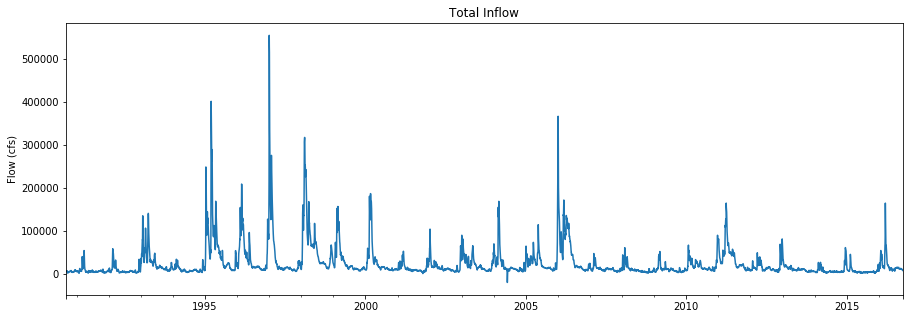

In [8]:
total_inflow=sum_sflow+sum_bflow
total_inflow=total_inflow['SEP1990':'SEP2016']

fig=total_inflow.plot(figsize=(15,5),title='Total Inflow')
_=fig.set_ylabel('Flow (cfs)')

# Read the output file for outflow
The outflow from DSM2 for the Delta has to go through channel 441. This flow is heavily tidal and the code below retrieves this from the model output file (HDF5 format) and tidally filters it

In [9]:
import pydsm.hydroh5
hydro=pydsm.hydroh5.HydroH5('output/historical_v82.h5')
mtz_outflow=hydro.get_channel_flow('441','downstream')
#flow4up=hydro.get_channel_flow('4','upstream')

Filter out the tidal signal using cosine lanczos (preferred) or godin filter
Also resample to daily flow (period average to daily)

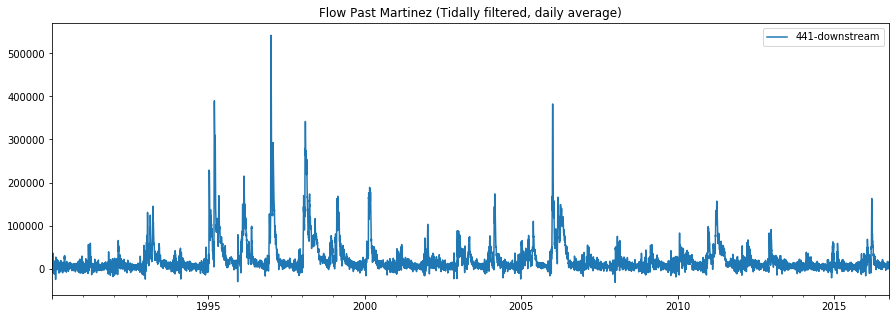

In [10]:
from vtools.functions.filter import cosine_lanczos, godin_filter
fmtz=cosine_lanczos(mtz_outflow,cutoff_period='40h')
#fmtz=godin_filter(mtz_outflow)
fdmtz=fmtz.resample('D').mean()
ax1=fdmtz.plot(figsize=(15,5),title='Flow Past Martinez (Tidally filtered, daily average)')
total_outflow=fdmtz

In [11]:
total_inflow.hvplot(label='Total Inflow')*total_outflow.hvplot(label='Total Outflow')

:Overlay
   .Curve.Total_Inflow  :Curve   [index]   (0)
   .Curve.Total_Outflow :Curve   [index]   (441-downstream)

In [12]:
(total_outflow.iloc[:,0]-total_inflow).resample('M').mean().hvplot.area(label='Mass Balance').opts(xrotation=45)

:Area   [index]   (0)